# Movie Recommender System

Most of our analysis is going to center on the data found in ratings.csv of the <a href="https://grouplens.org/datasets/movielens/100k/">MovieLens 100K DataSet</a>. More sophisticated techniques exist using the other data, but with so few users in our dataset (610) and so many predictions to make (almost 10k per user), incorporating too much of the additional information about movies runs the risk of simply overfitting our model to the specific preferences of these 610 users. If we were working with the <a href="https://grouplens.org/datasets/movielens/25m/">25M Dataset</a> (with data on 162k users) and had a weekend or two to let the model run, we would have incorporated that data. Further analysis is definitely required to refine this model.

As of this notebook, we're working with pretty straightforward Alternating Least Squares (ALS), so we'll be evaluating our predictions using Root Mean Square Error (RMSE). Our hyperparameters are:

* the number of latent factors (`rank`)
* the regularization parameter (`regParam`)
* the maximum number of iterations (`maxIter`)

Since our goal is to predict individual user ratings for individual movies, we need to explore the distributions of ratings given <i>by</i> users and the distribution of ratings given <i>to</i> movies to see what we're working with.

In order to keep cells as self-contained as possible (so only one cell needs to be run in order to produce the results/predictions/visualization), there is some redundancy built into in this notebook.

## Exploratory Data Analysis

First, we'll answer some basic questions about the data, to make sure the data is even usable. A recommender system won't be very useful if the data is bad.

In [1]:
import pandas as pd                    # to read in our data to a DataFrame
import matplotlib.pyplot as plt        # for plotting
df = pd.read_csv('data/ratings.csv')   # read the data from ratings.csv into a DataFrame
separator = '\n' + '-'*70 + '\n'

print(df.info())
print(separator)
print(df.describe())
print(separator)
print('Number of unique userId entries:', len(df.userId.unique()))
print('Number of unique movieId entries:', len(df.movieId.unique()))
print('Number of unique ratings:', len(df.rating.unique()))
print(separator)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

----------------------------------------------------------------------

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e

We can see we have no null values in any of the columns, which makes sense because these entries are made automatically when a user rates a movie.

userIDs range from 1 to 610. 

Movie IDs are unique inters between 1 and 193609, but only 9724 of those numbers are used (presumably only the 9724 movies that were rated by the 610 users in the datset).

There are 10 unique ratings: 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, and 5.

Timestamps represent seconds from midnight and are in a very unfriendly format. More advanced analysis could be done by seeing if there's a relationship between the order in which movies are rated and the rating given.

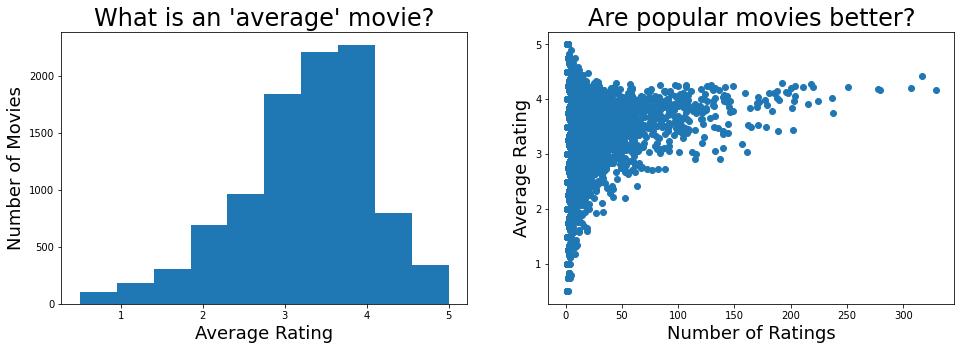

In [2]:
import pandas as pd                    # to read in our data to a DataFrame
import matplotlib.pyplot as plt        # for plotting
df = pd.read_csv('data/ratings.csv')   # read the data from ratings.csv into a DataFrame

# find the mean rating given to each individual movie
ratings_mean = df.groupby('movieId').rating.mean()

# find the number of times that movie was rated
ratings_count = df.groupby('movieId').rating.count()

# create side-by-side subplots
fig, (mean, count) = plt.subplots(1, 2, figsize=(16,5))

# plot a histogram of the mean ratings for each movie
mean.hist(ratings_mean)
mean.set_xlabel('Average Rating', fontsize=18)
mean.set_ylabel('Number of Movies', fontsize=18)
mean.set_title('What is an \'average\' movie?', fontsize=24)

# plot a scatterplot showing the relationship between number of ratings and mean rating
count.scatter(ratings_count, ratings_mean)
count.set_xlabel('Number of Ratings', fontsize=18)
count.set_ylabel('Average Rating', fontsize=18)
count.set_title('Are popular movies better?', fontsize=24)

# plt.savefig('popular-movies.png')

plt.show()

From the plots above, we can see that people tend to be pretty generous with their votes (with most movies having around a 4.0 rating––especially popular movies with many votes).

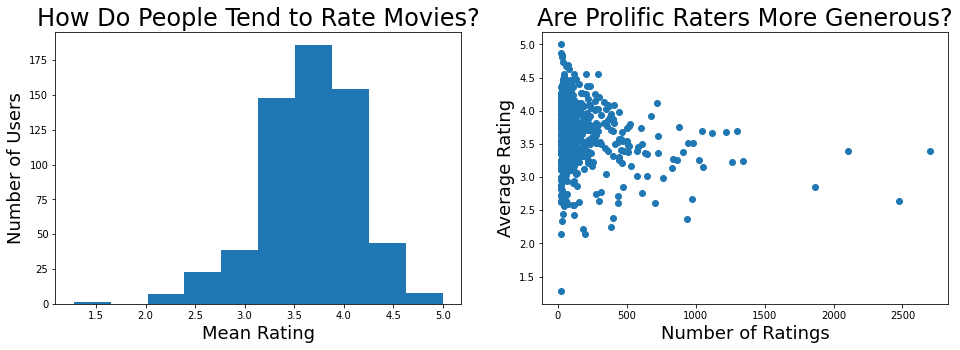

In [3]:
import pandas as pd                    # to read in our data to a DataFrame
import matplotlib.pyplot as plt        # for plotting
df = pd.read_csv('data/ratings.csv')   # read the data from ratings.csv into a DataFrame

# find the average rating given by each user
mean_ratings = df.groupby('userId').mean()['rating']

# find the total number of ratings given by each user
count_ratings = df.groupby('userId').count()['rating']

# make side-by-side subplots
fig, (hist, scatter) = plt.subplots(1,2, figsize=(16,5))

# plot the distribution of mean ratings given by each user
hist.hist(mean_ratings)
hist.set_xlabel('Mean Rating', fontsize=18)
hist.set_ylabel('Number of Users', fontsize=18)
hist.set_title('How Do People Tend to Rate Movies?', fontsize=24)

# plot a scatterplot showing the relationship between how many movies a user rates
# and the average rating they tend to give
scatter.scatter(count_ratings, mean_ratings)
scatter.set_xlabel('Number of Ratings', fontsize=18)
scatter.set_ylabel('Average Rating', fontsize=18)
scatter.set_title('Are Prolific Raters More Generous?', fontsize=24)

# plt.savefig('prolific-raters.png')

# display the graphs
plt.show()

   movieId  userId  rating  timestamp                        title  \
0        1       1     4.0  964982703             Toy Story (1995)   
1        3       1     4.0  964981247      Grumpier Old Men (1995)   
2        6       1     4.0  964982224                  Heat (1995)   
3       47       1     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       50       1     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


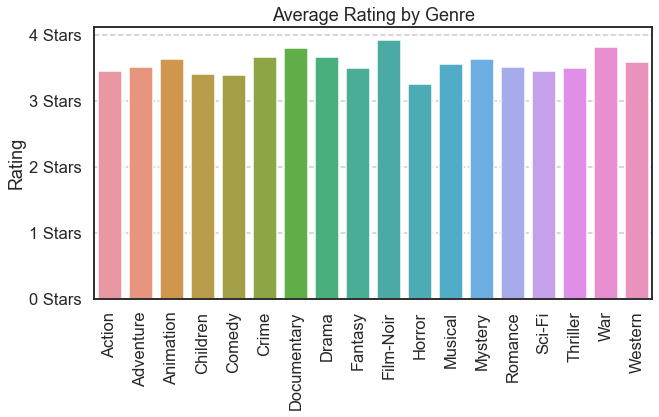

In [4]:
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
spark = pyspark.sql.SparkSession.builder.getOrCreate()

def grab_by_element(df, target_column, elem):
    """
    Arguments:  df, target_column, elem
    Returns the dataframe compose of those rows in the original dataframe "df" that have "elem" as an element of their entry
    for column "target_column"
    """
    return df.loc[df[target_column].apply(lambda x: elem in x)]

# code from Nick
# read in the dataset into pyspark DataFrame
ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=True,
                               header=True)
movies = spark.read.csv('data/movies.csv',
                               inferSchema=True,
                               header=True)
new_df = ratings.join(movies, on=['movieId'], how='left_outer')
df = new_df.select('*').toPandas()
print(df.head())

df.genres = df.genres.apply(lambda s: s.strip().split('|') if type(s)==str else s) 
#type check to try to avoid introducing errors if code is re-ran
type(df.genres[0]) 
# List of movie genres retrieved from the MovieLens README
movie_genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
               'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
                'Western']
data_for_chart={}
for g in movie_genres:
    data_for_chart[g]=grab_by_element(df,'genres',g).rating.mean()
global_context='talk'
fs=1.0
sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
plt.figure(figsize=(10,5))
ax=sns.barplot(x=list(data_for_chart.keys()),y=list(data_for_chart.values()),)#color=sns.color_palette('plasma')[0])
ax.set(ylabel='Rating')
ax.set(xlabel='');
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{int(s)} Stars' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.xticks(rotation=90)
plt.title(f'Average Rating by Genre')
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


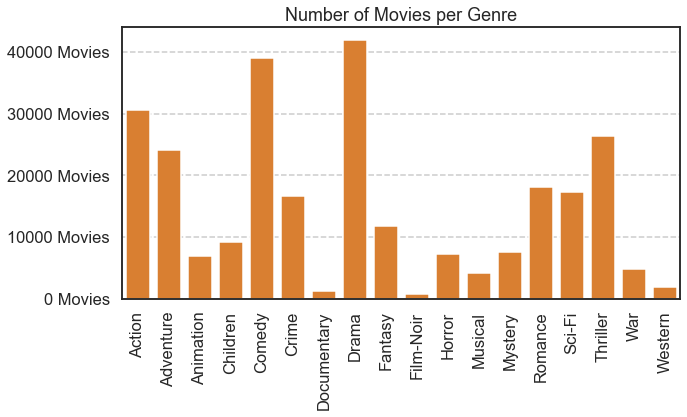

In [5]:
df.genres = df.genres.apply(lambda s: s.strip().split('|') if type(s)==str else s) 
#type check to try to avoid introducing errors if code is re-ran
type(df.genres[0]) 
# List of movie genres retrieved from the MovieLens README
movie_genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
               'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
                'Western']
data_for_chart={}
for g in movie_genres:
    data_for_chart[g]=grab_by_element(df,'genres',g).title.count()
global_context='talk'
fs=1.0
sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
plt.figure(figsize=(10,5))
ax=sns.barplot(x=list(data_for_chart.keys()),y=list(data_for_chart.values()), color=sns.color_palette('inferno')[-2])
#ax.set(ylabel='Rating')
ax.set(xlabel='');
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{int(s)} Movies' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.xticks(rotation=90)
plt.title(f'Number of Movies per Genre')
plt.show()

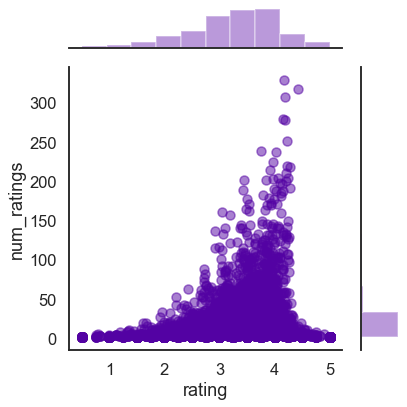

In [6]:
import seaborn as sns
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
p = sns.jointplot(x='rating', 
              y='num_ratings',
              data=ratings, 
              alpha=0.5,
              marginal_kws=dict(bins=10))
#p.fig.suptitle('Do Popular Movies Have Higher Average Ratings?')
p.fig.tight_layout()

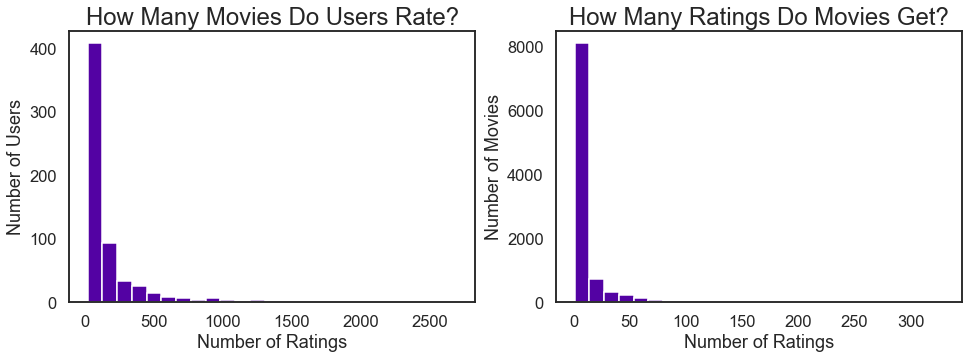

In [7]:
import pandas as pd                    # to read in our data to a DataFrame
import matplotlib.pyplot as plt        # for plotting
df = pd.read_csv('data/ratings.csv')   # read the data from ratings.csv into a DataFrame

users = df.groupby('userId').count()   # how many ratings did each user give?
movies = df.groupby('movieId').count() # how many ratings did each movie get?

# create two side-by-side plots
fig, (ax_users, ax_movies) = plt.subplots(1,2,figsize=(16,5))

import numpy as np
# make a histogram of how many ratings each user gives in the left plot
ax_users.hist(users.rating, bins=25)
ax_users.set_xlabel('Number of Ratings', fontsize=18)
ax_users.set_ylabel('Number of Users', fontsize=18)
ax_users.set_title('How Many Movies Do Users Rate?', fontsize=24)

# make a histogram of how many ratings each movie gets in the right plot
ax_movies.hist(movies.rating, bins=25)
ax_movies.set_xlabel('Number of Ratings', fontsize=18)
ax_movies.set_ylabel('Number of Movies', fontsize=18)
ax_movies.set_title('How Many Ratings Do Movies Get?', fontsize=24)

# plt.savefig('long-tails.png')

# display the graphs
plt.show()

Notice in the plots above that both movies and users have the same <a href="https://en.wikipedia.org/wiki/Long_tail">general shape</a> when it comes to number of ratings. The vast majority of individuals submit a very small number of ratings, and a very small number of individuals have a large number of ratings (meaning each row will have many missing values). This means our user-movie interaction matrix will be very <a href="https://en.wikipedia.org/wiki/Sparse_matrix">sparse</a>, so we'll be making predictions using <a href="https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html">Collaborative Filtering</a>. In particular, we'll be employing <a href="https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/">Alternating Least Squares</a> to complete the missing entries.

To accomplish this, we'll be using Pyspark's <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS">ALS module</a>.

In [8]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# code from Nick
# read in the dataset into pyspark DataFrame
ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=True,
                               header=True)
movies = spark.read.csv('data/movies.csv',
                               inferSchema=True,
                               header=True)
new_df = ratings.join(movies, on=['movieId'], how='left_outer')
df = new_df.select('*').toPandas()
df.head()

,movieId,userId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,1,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,6,1,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,47,1,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,1,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Testing the Vanilla Model

In the code below, we'll be testing the vanilla Alternating Least Squares model from pyspark. Note that the parameter values (rank=10, regParam = 0.1) are the default values.

In [9]:
import tqdm # for progress bars
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator # to evaluate our recommendations
from pyspark.ml.recommendation import ALS, ALSModel   # to make the actual recommendations

# if there is not currently a SparkSession, create one
# otherwise, get the SparkSession that already exists
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# just in case we need it at some point
#sc = spark.sparkContext

# read in the movie ratings
movie_ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=True,
                               header=True)

# split the data into 80% training and 20% test
mr_train, mr_test = movie_ratings.randomSplit([0.8, 0.2], seed=0)

# instantiate an ALS object with default values shown for reference
als = ALS(userCol='userId', 
          itemCol='movieId', 
          ratingCol='rating', 
          rank=10, # 10 is the default value for rank, but we'll be tuning this later
          regParam=0.1, # 0.1 is the default value for regParam, but we'll be tuning this too
          seed=0) # for reproducibility

# fit the model to the training data
als_model = als.fit(mr_train)

# make predictions based on the training data
train_predictions = als_model.transform(mr_train)

# create a RegressionEvaluator object for evaluating our predictions
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# actually evaluate our predictions
rmse = evaluator.evaluate(train_predictions.dropna())

# how'd we do?
print(f'rmse={rmse}')

rmse=0.5655719567133538


Based on the above (vanilla) model, we've got an RMSE of 0.564 on the training data. This means that, on average, our predictions are within 0.564 stars of the user's actual rating, which places it (on average) somewhere between between the correct star rating and the adjacent star rating. We anticipate some degree of overfitting, so we'll tune `regParam` and also examine `rank`.

## Hyperparameter Tuning

The makeshift "grid search" below will allow us to evaluate the RMSE at different values of `rank` and `regParam`, and save these values into a nested dictionary for plotting.

We'll be checking out the following values:

`rank` = {20, 30, 40, 50, 60, 70, 80}
`regParam` = {0.1, 0.2, 0.3, 0.4, 0.5}

In [12]:
# note that this cell might take up to 10 minutes to run

import tqdm # for progress bars
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator # to evaluate our recommendations
from pyspark.ml.recommendation import ALS, ALSModel   # to make the actual recommendations

# if there is not currently a SparkSession, create one
# otherwise, get the SparkSession that already exists
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# just in case we need it at some point
#sc = spark.sparkContext

movie_ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=True,
                               header=True)

# split the data into 80% training and 20% test
mr_train, mr_test = movie_ratings.randomSplit([0.8, 0.2], seed=0)

# split the training data into more 80% training data at 20% validation data for the
# parameter search below. ideally, we would be cross-validating across different folds,
# but in the interest of time we'll just use one fold.
mr_train, mr_validate = mr_train.randomSplit([0.8, 0.2], seed = 0)

# create a dictionary of the RMEs
rmses_training = dict()
rmses_validate = dict()

for num_factors in tqdm.trange(20, 81, 10):
    rmses_training[num_factors] = dict()
    rmses_validate[num_factors] = dict()
    for regularization_parameter in tqdm.tqdm([.1, .2, .3, .4, .5]):
        als = ALS(userCol='movieId',
                  itemCol='userId',
                  ratingCol='rating',
                  rank=num_factors,
                  regParam=regularization_parameter)
        als_model = als.fit(mr_train)
        train_predictions = als_model.transform(mr_train)
        valid_predictions = als_model.transform(mr_validate)
        evaluator = RegressionEvaluator(metricName='rmse',
                                        labelCol='rating',
                                        predictionCol='prediction')
        rmse_train = evaluator.evaluate(train_predictions.dropna())
        rmse_validate = evaluator.evaluate(valid_predictions.dropna())
        print(f'rmse_train={rmse_train}')
        print(f'rmse_validate={rmse_validate}')
        rmses_training[num_factors][regularization_parameter] = rmse_train
        rmses_validate[num_factors][regularization_parameter] = rmse_validate

 20%|██        | 1/5 [00:10<00:40, 10.15s/it]

rmse_train=0.4733689836088619
rmse_validate=0.9136560214593218



 40%|████      | 2/5 [00:19<00:30, 10.03s/it]

rmse_train=0.6734166113674722
rmse_validate=0.8883153642808833



 60%|██████    | 3/5 [00:29<00:19,  9.99s/it]

rmse_train=0.7948757970083495
rmse_validate=0.9164384425476925



 80%|████████  | 4/5 [00:39<00:09,  9.99s/it]

rmse_train=0.8646233585707638
rmse_validate=0.9593822461553219



  0%|          | 0/5 [00:00<?, ?it/s]

rmse_train=0.9215197555914117
rmse_validate=1.0061058042541362



 20%|██        | 1/5 [00:09<00:38,  9.70s/it]

rmse_train=0.4472003481912039
rmse_validate=0.9141948421673424



 40%|████      | 2/5 [00:19<00:29,  9.70s/it]

rmse_train=0.6711822258860791
rmse_validate=0.8909707368426528



 60%|██████    | 3/5 [00:29<00:19,  9.72s/it]

rmse_train=0.7960725775991662
rmse_validate=0.9179626433300104



 80%|████████  | 4/5 [00:39<00:09,  9.83s/it]

rmse_train=0.8656498093192401
rmse_validate=0.9601782700582078



  0%|          | 0/5 [00:00<?, ?it/s]

rmse_train=0.9217641983217698
rmse_validate=1.0062413516584912



 20%|██        | 1/5 [00:10<00:41, 10.40s/it]

rmse_train=0.4352292372290049
rmse_validate=0.913848404297129



 40%|████      | 2/5 [00:21<00:31, 10.52s/it]

rmse_train=0.6689877648050727
rmse_validate=0.8908693774120533



 60%|██████    | 3/5 [00:31<00:20, 10.33s/it]

rmse_train=0.7958359455746838
rmse_validate=0.9180073948075034



 80%|████████  | 4/5 [00:40<00:10, 10.19s/it]

rmse_train=0.8653575955773881
rmse_validate=0.9600875713924466



  0%|          | 0/5 [00:00<?, ?it/s]

rmse_train=0.9216779471499332
rmse_validate=1.0062466212731846



 20%|██        | 1/5 [00:12<00:49, 12.28s/it]

rmse_train=0.42896184352869976
rmse_validate=0.9141025075424032



 40%|████      | 2/5 [00:23<00:35, 11.87s/it]

rmse_train=0.6686873378275558
rmse_validate=0.892001896125413



 60%|██████    | 3/5 [00:34<00:23, 11.59s/it]

rmse_train=0.7964071620145644
rmse_validate=0.9184443765482461



 80%|████████  | 4/5 [00:44<00:11, 11.35s/it]

rmse_train=0.8655162864116576
rmse_validate=0.9602118463441299



  0%|          | 0/5 [00:00<?, ?it/s]

rmse_train=0.9217160105567589
rmse_validate=1.0062877532412362



 20%|██        | 1/5 [00:12<00:48, 12.13s/it]

rmse_train=0.4285866606774336
rmse_validate=0.9192976485559504



 40%|████      | 2/5 [00:23<00:35, 11.79s/it]

rmse_train=0.6686266953229105
rmse_validate=0.8921232369178245



 60%|██████    | 3/5 [00:34<00:23, 11.65s/it]

rmse_train=0.7957587507435224
rmse_validate=0.9179774458089511



 80%|████████  | 4/5 [00:45<00:11, 11.55s/it]

rmse_train=0.865429281810464
rmse_validate=0.9599833479542814



  0%|          | 0/5 [00:00<?, ?it/s]

rmse_train=0.9216342146124008
rmse_validate=1.0061526599962716



 20%|██        | 1/5 [00:11<00:47, 11.93s/it]

rmse_train=0.4262412443720082
rmse_validate=0.9165804795515861



 40%|████      | 2/5 [00:24<00:36, 12.16s/it]

rmse_train=0.6679819376239348
rmse_validate=0.8918539912137825



 60%|██████    | 3/5 [00:36<00:23, 11.98s/it]

rmse_train=0.7957431377206015
rmse_validate=0.9180058485681308



 80%|████████  | 4/5 [00:47<00:11, 11.85s/it]

rmse_train=0.8654799834180409
rmse_validate=0.9600999614874806



  0%|          | 0/5 [00:00<?, ?it/s]

rmse_train=0.921688275781742
rmse_validate=1.0062041272807145



 20%|██        | 1/5 [00:12<00:51, 12.76s/it]

rmse_train=0.4256173958038236
rmse_validate=0.9172729424309263



 40%|████      | 2/5 [00:26<00:38, 12.96s/it]

rmse_train=0.6677579736362781
rmse_validate=0.8919756752567923



 60%|██████    | 3/5 [00:39<00:25, 12.93s/it]

rmse_train=0.795679951376506
rmse_validate=0.9179165257093213



 80%|████████  | 4/5 [00:51<00:12, 12.88s/it]

rmse_train=0.8651783600470102
rmse_validate=0.9599083449633314



100%|██████████| 7/7 [06:27<00:00, 55.33s/it]

rmse_train=0.9215834215713581
rmse_validate=1.0061688449899502


## Exploring the Results of the Grid Search

The plots below aggregate and display the results of the grid search.

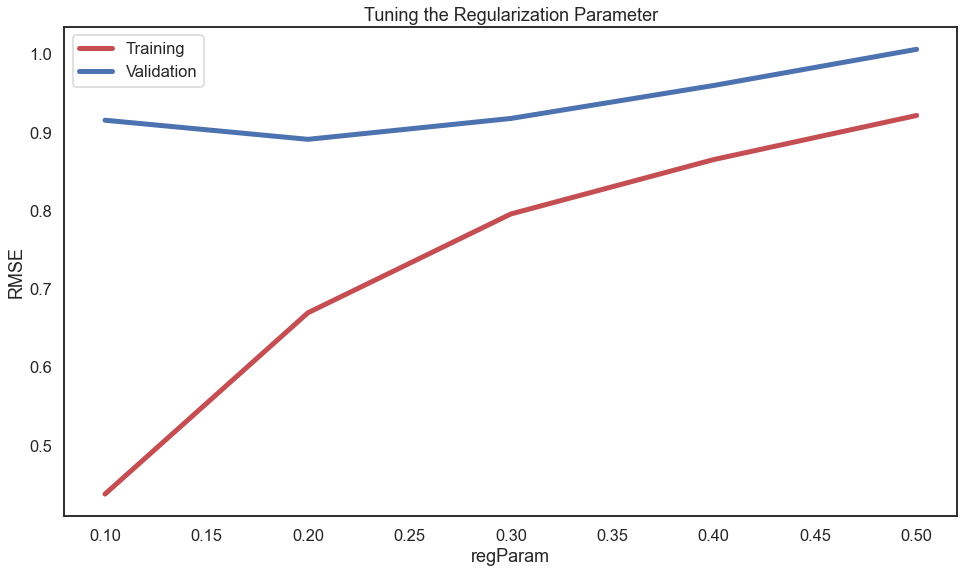

In [26]:
# Plotting the RMSEs for various values of the regularization parameter

# imports to keep this cell as self-contained as we can manage
import matplotlib.pyplot as plt
import pandas as pd

# turn the dictionaries produced by the grid search into dataframes
df_training = pd.DataFrame(rmses_training)
df_validate = pd.DataFrame(rmses_validate)

# good size
plt.figure(figsize=(16,9))

# each column has the same general shape, so we'll just graph their mean
plt.plot(df_training.mean(axis=1), c='r', lw=5)
plt.plot(df_validate.mean(axis=1), c='b', lw=5)

plt.xlabel('regParam')
plt.ylabel('RMSE')
plt.title('Tuning the Regularization Parameter')
plt.legend(['Training', 'Validation'])
plt.show()

As we can see from the above plot, the RMSE for this particular set of validation data is minimized when `regParam` is equal to 0.2 across all values of `rank`, which represents the latent factors in the model (`num_factors`).

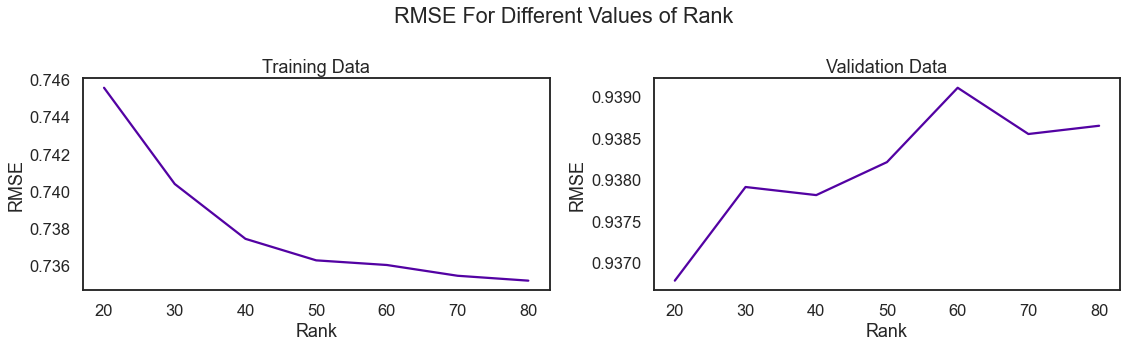

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df_training = pd.DataFrame(rmses_training)
df_validate = pd.DataFrame(rmses_validate)

print(df_training, '\n\n')
print(df_validate)

# create two plots next to each other
fig, (ax_training, ax_validate) = plt.subplots(1, 2, figsize=(16,5))

# plot the graph on the left (mean for training data)
ax_training.plot(df_training.T.mean(axis=1))
ax_training.set_xlabel('Rank')
ax_training.set_ylabel('RMSE')
ax_training.set_title('Training Data')

# plot the graph on the right (mean for validation data)
ax_validate.plot(df_validate.T.mean(axis=1))
ax_validate.set_xlabel('Rank')
ax_validate.set_ylabel('RMSE')
ax_validate.set_title('Validation Data')

# slap a title up top
plt.suptitle('RMSE For Different Values of Rank')

# make the spacing friendlier
fig.tight_layout()

As we can see in the graph on the left, on average we reach a point of diminishing returns in the training data when it comes to increasing the value of `rank` when we reach about 50 latent factors. 

The change in the graph on the right looks dramatic, but the maximum and minimum values differ from each other by about 0.1%.

With a larger set of training data (such as the MovieLens 25m dataset with 162k users), we could push the tuning further, but with only 610 users, we're just going to be overfitting to those specific users' preferences.

## Training and Testing the Model

In the cell below, we train the model with the same training data used in the above hyperparameter tuning, and then test it on the test data. Note that we've been using `seed=0` to ensure there is no data leakage.

In [43]:
import tqdm # for progress bars
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator # to evaluate our recommendations
from pyspark.ml.recommendation import ALS, ALSModel   # to make the actual recommendations

# if there is not currently a SparkSession, create one
# otherwise, get the SparkSession that already exists
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# just in case we need it at some point
#sc = spark.sparkContext

movie_ratings = spark.read.csv('data/ratings.csv',
                               inferSchema=True,
                               header=True)

# split the data into 80% training and 20% test
# note from the random seed that this is still the same set of training data that
# we used in the parameter search.
mr_train, mr_test = movie_ratings.randomSplit([0.8, 0.2], seed=0)

# instantiate the ALS object with 50 latent factors and a regularization
# parameter of 0.2
als = ALS(userCol='movieId', 
          itemCol='userId', 
          ratingCol='rating', 
          rank=50, 
          regParam=.2)

# fit the model to the training data
als_model = als.fit(mr_train)

# predict for the training data
train_predictions = als_model.transform(mr_train)

# predict for the test data
test_predictions = als_model.transform(mr_test)

# create an evaluator object
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='rating',
                                predictionCol='prediction')

# compute the rmses
rmse_train = evaluator.evaluate(train_predictions.dropna())
rmse_test = evaluator.evaluate(test_predictions.dropna())

# 
print('RMSE (training): {},\n    RMSE (test): {}'.format(rmse_train, rmse_test))

RMSE (training): 0.7017034009238553,
    RMSE (test): 0.8888130615184012


The RMSEs above show that, on average, our model's prediction is less than one star away from the user's true rating for that movie.

Because the difference between adjacent star ratings is totally subjective (and can even vary with the watcher's mood), this is a good place for our predictions to land. If our RMSE were greater than 1.5, we would have an issue––that would mean that we could be up to 2 stars away from the correct rating, which could be the difference between "liked it" (4 stars) and "didn't like it" (2 stars).

Now let's make some recommendations!

## Recommendations

But RMSEs don't make a good recommender system... recommendations do! Let's choose an arbitrary user who has ratings in our test data (`userId` = 471) and see how well we did.

In [113]:
# get top 10 recommendations for all users
# these movies could be displayed on the user's homepage
user_recs = als_model.recommendForAllItems(10)
ur = user_recs.toPandas().set_index('userId')

# let's just load movie Titles And Genres (tag) once
movie_tag = pd.read_csv('data/movies.csv')

def get_movie(movie_id):
    """
    Looks up a movie by ID and returns its title.
    
    ------------------------------------------------------------------
    
    Parameters:
    movie_id (int): the movieId in the dataset.
    
    Returns:
    The title of the movie (str)
    """
    return movie_tag[movie_tag.movieId == movie_id].title.iloc[0]

def print_recommendations(user_id):
    """
    Prints the titles of the top 10 recommendations for a user, along
    with the predicted rating.
    
    ------------------------------------------------------------------
    
    Parameters:
    user_id (int): the user whose recommendations we want to print.
    
    Returns:
    None
    """
    print('Recommendations for userId:', user_id)
    recs = ur.loc[user_id, 'recommendations']
    for i in range(len(recs)):
        print('{} ({})'.format(get_movie(list(ur.loc[user_id, 'recommendations'][i])[0]),
              ur.loc[user_id, 'recommendations'][i][1]))

### Predictions for `userId` 471

The example below shows our top 10 recommendations for `userId` 471.

In [114]:
print_recommendations(471)

Recommendations for userId: 471
Neon Genesis Evangelion: Death & Rebirth (Shin seiki Evangelion Gekijô-ban: Shito shinsei) (1997) (4.725411415100098)
On the Beach (1959) (4.725411415100098)
Seve (2014) (4.5124359130859375)
The Big Bus (1976) (4.5124359130859375)
Jetée, La (1962) (4.468662261962891)
Bad Boy Bubby (1993) (4.438012599945068)
Saving Face (2004) (4.436741352081299)
Bossa Nova (2000) (4.4339799880981445)
Crossing Delancey (1988) (4.429937839508057)
Lady Jane (1986) (4.429937839508057)


Now that we've got some recommendations, let's compare our predicted ratings to `userId` 471's actual ratings.

In [115]:
# now let's compare the predictions we made for 471 that were not in our training data.

user_471 = als_model.transform(mr_test.filter(mr_test.userId == 471)).toPandas()
user_471['title'] = user_471.movieId.apply(get_movie)
user_471 = user_471[['title', 'rating', 'prediction']]
user_471

,title,rating,prediction
0,Toy Story 3 (2010),4.5,3.534358
1,Toy Story (1995),5.0,3.401723
2,The Imitation Game (2014),3.0,3.604021
3,Inception (2010),4.0,3.588652
4,Pirates of the Caribbean: The Curse of the Bla...,3.5,3.138060
5,"Monsters, Inc. (2001)",4.0,3.380135


Note that most of the ratings were within our RMSE of the user's actual rating, with the only exception being Toy Story. We're okay underestimating ratings sometimes––that means the movie will be a pleasant surprise!

## Conclusions

Our recommendation system tends to recommend movies that are between the user's actual rating and the adjacent star rating.

There is some degree of overfitting to these specific 610 users' preferences, but that could be overcome on a larger scale by using a larger dataset (such as the MovieLens 25m).